In [ ]:
# Abigail Kelly
# Assignment 1
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.sparse import diags

In [ ]:
def calculate_L2_norm(array_numerical, array_analytical, flag = 0):
    # Extract the last column of the numerical and analytical arrays
    if flag == 0:
      u_numerical = array_numerical[:, -1]
    else:
      u_numerical = array_numerical[-1]
    u_analytical = array_analytical[:, -1]

    # Calculate the difference between numerical and analytical solutions
    diff = u_numerical - u_analytical

    # Calculate the L2 norm
    l2_norm = np.linalg.norm(diff) / np.sqrt(len(diff))

    return l2_norm

def calculate_infinity_norm(array_numerical, array_analytical, flag = 0):
    # Extract the last column of the numerical and analytical arrays
    if flag == 0:
      u_numerical = array_numerical[:, -1]
    else:
      u_numerical = array_numerical
    u_analytical = array_analytical[:, -1]

    # Calculate the difference between numerical and analytical solutions
    diff = u_numerical - u_analytical

    # Calculate the infinity norm
    infinity_norm = np.linalg.norm(diff, ord=np.inf)

    return infinity_norm

In [ ]:
# Question 1 Functions
def q1_analytical(max_x, dx, max_t, dt, flag = 0):
  M = int(max_x / dx) + 1
  N = int(max_t / dt) + 1
  r = dt / dx**2
  analytical = np.zeros((M,N))

  for i in range(M):
    x = i * dx
    for j in range(N):
      t = j * dt
      for n in range(1, 100):
        analytical[i][j] += (1 - (-1)**n) * (2 / (np.pi * n)) * np.sin((n * np.pi * x) / 2) * np.exp((-n**2 * np.pi**2 * t) / 4)

  if flag != 0:
    x = np.linspace(0, max_x, M)
    t = np.linspace(0, max_t, N)
    X, T = np.meshgrid(x, t)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, analytical.T, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    ax.set_title(f'Question 1d: Analytical Solution tau = {dt}, h = {dx}')
    plt.show()

  return analytical

def q1_euler(max_x, dx, max_t, dt, flag = 0):
  M = int(max_x / dx) + 1
  N = int(max_t / dt) + 1
  r = dt / dx**2
  u = np.zeros((M,N))

  u[0, :] = 0.0  # Boundary condition at x=0
  u[-1, :] = 0.0  # Boundary condition at x=L
  u[:, 0] = 1.0  # Initial condition
  # Constructing the matrix A for the linear system
  A = np.zeros((M-2, M-2))
  np.fill_diagonal(A, 1 + 2*r)
  np.fill_diagonal(A[1:], -r)
  np.fill_diagonal(A[:, 1:], -r)

  b = np.zeros(M-2)

  # Iterating over time steps
  for j in range(0, N-1):
    b = u[1:-1, j]
    b[0] += r * u[0, j+1]
    b[-1] += r * u[-1, j+1]
    u[1:-1, j+1] = np.linalg.solve(A, b)

  if flag != 0:
    x = np.linspace(0, 1, M)
    t = np.linspace(0, dt*M, N)
    X, T = np.meshgrid(x, t)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f'Question 1d: Backward Euler tau = {dt}, h = {dx}')
    ax.plot_surface(X, T, u.T, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    plt.show()

  return u

def q1_crank(max_x, dx, max_t, dt, flag = 0):
  M = int(max_x / dx)
  N = int(max_t / dt)
  r = dt / dx**2

  # Boundary conditions
  x = np.linspace(0, max_x, M+1)
  t = np.linspace(0, max_t, N+1)

  A = np.diag((2 + 2 * r) * np.ones(M - 1)) + np.diag((-r) * np.ones(M - 2), 1) + np.diag((-r) * np.ones(M - 2), -1)
  B = np.diag((2 - 2 * r) * np.ones(M - 1)) + np.diag((r) * np.ones(M - 2), 1) + np.diag((r) * np.ones(M - 2), -1)

  C = np.zeros((M+1,N+1))
  C0 = lambda x: np.ones_like(x)
  C[:,0] = C0(x)
  b = np.zeros(M)
  for j in range(N):
      b = np.dot(B, C[1:M, j])
      C[1:M, j+1] = np.linalg.solve(A, b)

  if flag != 0:
    x = np.arange(0, max_x + dx, dx)
    t = np.arange(0, max_t + dt, dt)
    X, T = np.meshgrid(x, t)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f'Question 1d: Crank Nicolson tau = {dt}, h = {dx}')
    ax.plot_surface(X, T, C.T, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    plt.show()

  return C

def q1_extrapolation(max_x, dx, max_t, dt):
  M = int(max_x / dx) + 1
  N = int(max_t / dt) + 1
  r = dt / dx**2
  e = np.zeros((N,M))

  e[:, 0] = 0 # boundary condition
  e[:, -1] = 0 # boundary condition
  e[0] = 1 # initial condition

  A = np.zeros((M-2, M-2))
  np.fill_diagonal(A, -2)
  np.fill_diagonal(A[1:], 1)
  np.fill_diagonal(A[:, 1:], 1)

  I = np.identity(M-2)

  v1 = np.linalg.inv(I - 2 * r * A)
  v2 = np.linalg.inv(I - r * A).dot(np.linalg.inv(I - r * A))
  v = 2 * v2 - v1

  for j in range(0, N-2):
    u = e[j][1:-1]
    e[j+2][1:-1] = v.dot(u)

  return e

max_t = 1
max_x = 2
dx = 0.1
dt = 0.1
max_t = 1

analytical = q1_analytical(max_x, dx, max_t, dt)
euler = q1_euler(max_x, dx, max_t, dt)
crank = q1_crank(max_x, dx, max_t, dt)
e = q1_extrapolation(max_x, dx, max_t, dt)

In [ ]:
# Question 1a
tau = np.array([0.1, 0.01])
h = np.array([0.1, 0.05, 0.025])
max_t = 1
max_x = 2
euler_L2_norms = []
crank_L2_norms = []
extrapolation_L2_norms = []
euler_inf_norms = []
crank_inf_norms = []
extrapolation_inf_norms = []

for dt in tau:
    for dx in h:
      analytical = q1_analytical(max_x, dx, max_t, dt)
      euler = q1_euler(max_x, dx, max_t, dt)
      crank = q1_crank(max_x, dx, max_t, dt)
      extrapolation = q1_extrapolation(max_x, dx, max_t, dt)

      L2_norm_crank = calculate_L2_norm(crank, analytical)
      L2_norm_euler = calculate_L2_norm(euler, analytical)
      L2_norm_extrapolation = calculate_L2_norm(extrapolation, analytical, 1)
      euler_L2_norms.append(L2_norm_euler)
      crank_L2_norms.append(L2_norm_crank)
      extrapolation_L2_norms.append(L2_norm_extrapolation)

      L_inf_norm_crank = calculate_infinity_norm(crank, analytical)
      L_inf_norm_euler = calculate_infinity_norm(euler, analytical)
      L_inf_norm_extrapolation = np.linalg.norm(extrapolation[-1] - analytical[:, -1], ord=np.inf)
      euler_inf_norms.append(L_inf_norm_euler)
      crank_inf_norms.append(L_inf_norm_crank)
      extrapolation_inf_norms.append(L_inf_norm_extrapolation)

print(f'                               L 2 Errors')
print(f'                               tau = 0.1                           tau = 0.01')
print(f'Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Crank-Nicolson        {crank_L2_norms[0]:.2e}  {crank_L2_norms[1]:.2e}   {crank_L2_norms[2]:.2e}        {crank_L2_norms[3]:.2e}  {crank_L2_norms[4]:.2e}   {crank_L2_norms[5]:.2e}')
print(f'Backward-Difference   {euler_L2_norms[0]:.2e}  {euler_L2_norms[1]:.2e}   {euler_L2_norms[2]:.2e}        {euler_L2_norms[3]:.2e}  {euler_L2_norms[4]:.2e}   {euler_L2_norms[5]:.2e}')
print(f'Extrapolation         {extrapolation_L2_norms[0]:.2e}  {extrapolation_L2_norms[1]:.2e}   {extrapolation_L2_norms[2]:.2e}        {extrapolation_L2_norms[3]:.2e}  {extrapolation_L2_norms[4]:.2e}   {extrapolation_L2_norms[5]:.2e}')
print('\n')
print(f'                             L inf Errors')
print(f'                               tau = 0.1                           tau = 0.01')
print(f'Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Crank-Nicolson        {crank_inf_norms[0]:.2e}  {crank_inf_norms[1]:.2e}   {crank_inf_norms[2]:.2e}        {crank_inf_norms[3]:.2e}  {crank_inf_norms[4]:.2e}   {crank_inf_norms[5]:.2e}')
print(f'Backward-Difference   {euler_inf_norms[0]:.2e}  {euler_inf_norms[1]:.2e}   {euler_inf_norms[2]:.2e}        {euler_inf_norms[3]:.2e}  {euler_inf_norms[4]:.2e}   {euler_inf_norms[5]:.2e}')
print(f'Extrapolation         {extrapolation_inf_norms[0]:.2e}  {extrapolation_inf_norms[1]:.2e}   {extrapolation_inf_norms[2]:.2e}        {extrapolation_inf_norms[3]:.2e}  {extrapolation_inf_norms[4]:.2e}   {extrapolation_inf_norms[5]:.2e}')

                               L 2 Errors
                               tau = 0.1                           tau = 0.01
Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025
-----------------------------------------------------------------------------------------
Crank-Nicolson        2.00e-02  6.37e-02   9.88e-02        2.15e-04  4.74e-05   1.69e-05
Backward-Difference   2.25e-02  2.26e-02   2.27e-02        2.49e-03  2.35e-03   2.32e-03
Extrapolation         1.52e+00  2.13e+00   2.99e+00        1.16e+00  1.64e+00   2.32e+00


                             L inf Errors
                               tau = 0.1                           tau = 0.01
Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025
-----------------------------------------------------------------------------------------
Crank-Nicolson        5.62e-02  2.79e-01   5.49e-01        3.12e-04  6.79e-05   6.70e-05
Backward-Difference   3.26e-02  3.24e-02  

[0.002487328750155782, 0.0047438010938912955, 0.0070916230333839154, 0.009236122494166702, 0.011471112523082803, 0.014456084413567554, 0.01635100328761133, 0.019112266634344687, 0.020599844257192284, 0.022520334224887913]
[0.00021532499400172238, 0.0001874271114616614, 0.00014141905604302913, 8.168377336813815e-05, 0.0004033685259049298, 0.002031552157005406, 0.004788785411585155, 0.009485699857373185, 0.014214866603260868, 0.020028666865264264]


<Figure size 640x480 with 0 Axes>

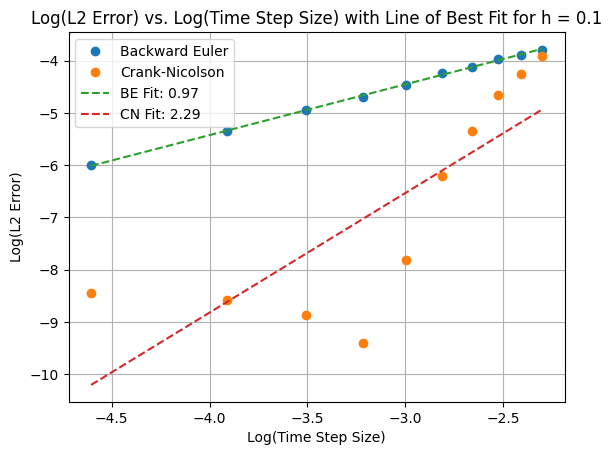

In [ ]:
# Question 1b

tau = np.arange(0.01, 0.11, 0.01)
dx = 0.1
max_x = 2
max_t = 1
errors_CN = []
errors_BE = []
for dt in tau:
    analytical = q1_analytical(max_x, dx, max_t, dt)
    euler = q1_euler(max_x, dx, max_t, dt)
    crank = q1_crank(max_x, dx, max_t, dt)

    # Calculate L2 error for each method
    error_BE = calculate_L2_norm(euler, analytical)
    error_CN = calculate_L2_norm(crank, analytical)
    errors_BE.append(error_BE)
    errors_CN.append(error_CN)
print(errors_BE)
print(errors_CN)
plt.figure()
log_tau = np.log(tau)
log_errors_BE = np.log(errors_BE)
log_errors_CN = np.log(errors_CN)

plt.figure()
plt.plot(log_tau, log_errors_BE, marker='o', linestyle='', label='Backward Euler')
plt.plot(log_tau, log_errors_CN, marker='o', linestyle='', label='Crank-Nicolson')

# Perform linear regression to find the slope (order of convergence)
slope_BE, intercept_BE, _, _, _ = linregress(log_tau, log_errors_BE)
slope_CN, intercept_CN, _, _, _ = linregress(log_tau, log_errors_CN)

plt.plot(log_tau, intercept_BE + slope_BE * log_tau, '--', label=f'BE Fit: {slope_BE:.2f}')
plt.plot(log_tau, intercept_CN + slope_CN * log_tau, '--', label=f'CN Fit: {slope_CN:.2f}')

plt.xlabel('Log(Time Step Size)')
plt.ylabel('Log(L2 Error)')
plt.title(f'Log(L2 Error) vs. Log(Time Step Size) with Line of Best Fit for h = {dx}')
plt.legend()
plt.grid(True)
plt.show()

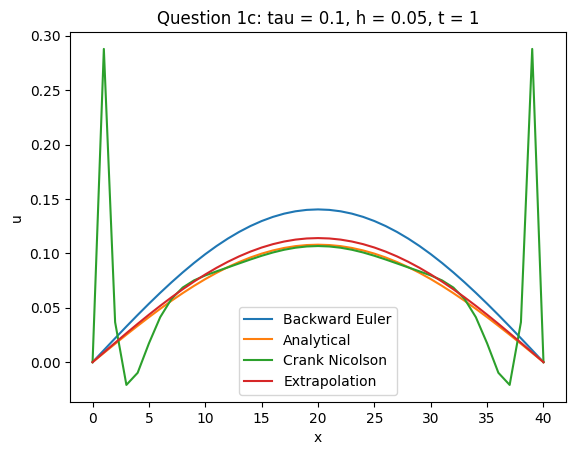

In [ ]:
# Question 1c: Plot numerical and analytical solutions for tao = 0.1, h = 0.05 at t = 1
max_t = 1
max_x = 2
dx = 0.05
dt = 0.1
max_t = 1

analytical = q1_analytical(max_x, dx, max_t, dt)
euler = q1_euler(max_x, dx, max_t, dt)
crank = q1_crank(max_x, dx, max_t, dt)
e = q1_extrapolation(max_x, dx, max_t, dt)

plt.plot(euler[:,-1], label='Backward Euler')
plt.plot(analytical[:,-1], label='Analytical')
plt.plot(crank[:,-1], label='Crank Nicolson')
plt.plot(e[-1], label = 'Extrapolation')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title(f'Question 1c: tau = {dt}, h = {dx}, t = 1')
plt.show()

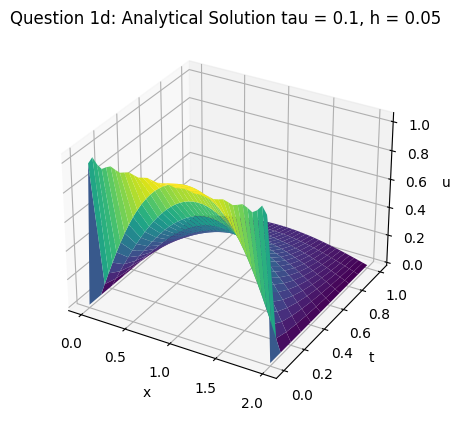

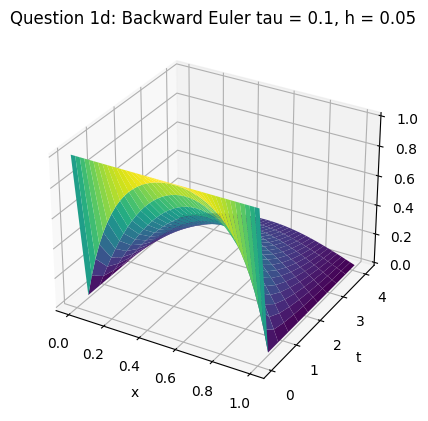

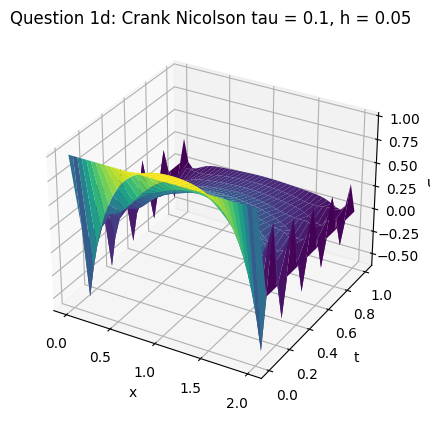

In [ ]:
# Question 1d: Give surface plot of both methods and analytical solution for tao = 0.1, h = 0.05
max_t = 1
dt = 0.1
max_x = 2
dx = 0.05

analytical = q1_analytical(max_x, dx, max_t, dt, 1)
euler = q1_euler(max_x, dx, max_t, dt, 1)
crank = q1_crank(max_x, dx, max_t, dt, 1)

In [ ]:
# Question 2 Functions

def q2_analytical(max_x, dx, max_t, dt, k, flag = 0):
  M = int(max_x / dx) + 1
  N = int(max_t / dt) + 1
  r = k * dt / dx**2
  analytical = np.zeros((M,N))

  for i in range(M):
    x = i * dx
    for j in range(N):
      t = j * dt
      for n in range(1, 15):
        analytical[i][j] += (4 / ( n * np.pi)) * np.sin((n * np.pi) / 2) * np.sin((n * np.pi) / 4) * np.sin(n * np.pi * x) * np.exp(-k * n**2 * np.pi**2 * t)

  if flag != 0:
    x = np.linspace(0, max_x, M)
    t = np.linspace(0, max_t, N)
    X, T = np.meshgrid(x, t)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, analytical.T, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    ax.set_title(f'Question 2d: Analytical Solution tau = {dt}, h = {dx}, kappa = {k}')
    plt.show()

  return analytical


def q2_euler(max_x, dx, max_t, dt, k, flag = 0):
  M = int(max_x / dx) + 1
  N = int(max_t / dt) + 1
  r = k * dt / dx**2
  u = np.zeros((M,N))

  # Initial condition
  x_count = 0
  for i in range(M):
    if 0 < x_count < 0.25:
      u[i, 0] = 0
    elif 0.25 <= x_count <= 0.75:
      u[i, 0] = 1
    elif 0.75 < x_count < 1:
      u[i, 0] = 0
    x_count += dx

  # Boundary conditions
  u[0, :] = 0  # Boundary condition at x=0
  u[-1, :] = 0  # Boundary condition at x=L

  # Constructing the matrix A for the linear system
  A = np.zeros((M-2, M-2))
  np.fill_diagonal(A, 1 + 2*r)
  np.fill_diagonal(A[1:], -r)
  np.fill_diagonal(A[:, 1:], -r)

  # Iterating over time steps
  for j in range(0, N-1):
    b = u[1:-1, j]
    b[0] += r * u[0, j+1]
    b[-1] += r * u[-1, j+1]
    u[1:-1, j+1] = np.linalg.solve(A, b)

  if flag != 0:
    x = np.linspace(0, 1, M)
    t = np.linspace(0, dt*M, N)
    X, T = np.meshgrid(x, t)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f'Question 2d: Backward Euler tau = {dt}, h = {dx}, kappa = {k}')
    ax.plot_surface(X, T, u.T, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    plt.show()

  return u

def q2_crank(max_x, dx, max_t, dt, k, flag = 0):
  M = int(max_x / dx)
  N = int(max_t / dt)
  r = k * dt / dx**2
  C = np.zeros((M+1,N+1))

  # Boundary conditions
  x = np.linspace(0, max_x, M+1)
  t = np.linspace(0, max_t, N+1)

  A = np.diag((2 + 2 * r) * np.ones(M - 1)) + np.diag((-r) * np.ones(M - 2), 1) + np.diag((-r) * np.ones(M - 2), -1)
  B = np.diag((2 - 2 * r) * np.ones(M - 1)) + np.diag((r) * np.ones(M - 2), 1) + np.diag((r) * np.ones(M - 2), -1)

  # Initial condition
  for i in range(1, M):
    x_count = i * dx
    if 0 < x_count < 0.25:
      C[i, 0] = 0
    elif 0.25 <= x_count <= 0.75:
      C[i, 0] = 1
    elif 0.75 < x_count < 1:
      C[i, 0] = 0

  b = np.zeros(M)
  for j in range(N):
    b = np.dot(B, C[1:M, j])
    C[1:M, j+1] = np.linalg.solve(A, b)

  if flag != 0:
    x = np.arange(0, max_x + dx, dx)
    t = np.arange(0, max_t + dt, dt)
    X, T = np.meshgrid(x, t)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f'Question 2d: Crank Nicolson tau = {dt}, h = {dx}, kappa = {k}')
    ax.plot_surface(X, T, C.T, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    plt.show()

  return C

In [ ]:
# Question 2a
tau = np.array([0.1, 0.01])
h = np.array([0.1, 0.05, 0.025])
kappa = np.array([1, 5, 10])
max_t = 1
max_x = 1
euler_L2_norms = []
crank_L2_norms = []
euler_inf_norms = []
crank_inf_norms = []

for k in kappa:
  for dt in tau:
    for dx in h:
      analytical = q2_analytical(max_x, dx, max_t, dt, k)
      euler = q2_euler(max_x, dx, max_t, dt, k)
      crank = q2_crank(max_x, dx, max_t, dt, k)

      L2_norm_crank = calculate_L2_norm(crank, analytical)
      L2_norm_euler = calculate_L2_norm(euler, analytical)
      euler_L2_norms.append(L2_norm_euler)
      crank_L2_norms.append(L2_norm_crank)
      L_inf_norm_crank = calculate_infinity_norm(crank, analytical)
      L_inf_norm_euler = calculate_infinity_norm(euler, analytical)
      euler_inf_norms.append(L_inf_norm_euler)
      crank_inf_norms.append(L_inf_norm_crank)

print(f'                          L 2 Errors kappa = 1')
print(f'                               tau = 0.1                           tau = 0.01')
print(f'Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Crank-Nicolson        {crank_L2_norms[0]:.2e}  {crank_L2_norms[1]:.2e}   {crank_L2_norms[2]:.2e}        {crank_L2_norms[3]:.2e}  {crank_L2_norms[4]:.2e}   {crank_L2_norms[5]:.2e}')
print(f'Backward-Difference   {euler_L2_norms[0]:.2e}  {euler_L2_norms[1]:.2e}   {euler_L2_norms[2]:.2e}        {euler_L2_norms[3]:.2e}  {euler_L2_norms[4]:.2e}   {euler_L2_norms[5]:.2e}')
print('\n')
print(f'                        L inf Errors kappa = 1')
print(f'                               tau = 0.1                           tau = 0.01')
print(f'Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Crank-Nicolson        {crank_inf_norms[0]:.2e}  {crank_inf_norms[1]:.2e}   {crank_inf_norms[2]:.2e}        {crank_inf_norms[3]:.2e}  {crank_inf_norms[4]:.2e}   {crank_inf_norms[5]:.2e}')
print(f'Backward-Difference   {euler_inf_norms[0]:.2e}  {euler_inf_norms[1]:.2e}   {euler_inf_norms[2]:.2e}        {euler_inf_norms[3]:.2e}  {euler_inf_norms[4]:.2e}   {euler_inf_norms[5]:.2e}')
print('\n')
print(f'                          L 2 Errors kappa = 5')
print(f'                               tau = 0.1                           tau = 0.01')
print(f'Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Crank-Nicolson        {crank_L2_norms[6]:.2e}  {crank_L2_norms[7]:.2e}   {crank_L2_norms[8]:.2e}        {crank_L2_norms[9]:.2e}  {crank_L2_norms[10]:.2e}   {crank_L2_norms[11]:.2e}')
print(f'Backward-Difference   {euler_L2_norms[6]:.2e}  {euler_L2_norms[7]:.2e}   {euler_L2_norms[8]:.2e}        {euler_L2_norms[9]:.2e}  {euler_L2_norms[10]:.2e}   {euler_L2_norms[11]:.2e}')
print('\n')
print(f'                        L inf Errors kappa = 5')
print(f'                               tau = 0.1                           tau = 0.01')
print(f'Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Crank-Nicolson        {crank_inf_norms[6]:.2e}  {crank_inf_norms[7]:.2e}   {crank_inf_norms[8]:.2e}        {crank_inf_norms[9]:.2e}  {crank_inf_norms[10]:.2e}   {crank_inf_norms[11]:.2e}')
print(f'Backward-Difference   {euler_inf_norms[6]:.2e}  {euler_inf_norms[7]:.2e}   {euler_inf_norms[8]:.2e}        {euler_inf_norms[9]:.2e}  {euler_inf_norms[10]:.2e}   {euler_inf_norms[11]:.2e}')
print('\n')
print(f'                          L 2 Errors kappa = 10')
print(f'                               tau = 0.1                           tau = 0.01')
print(f'Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Crank-Nicolson        {crank_L2_norms[12]:.2e}  {crank_L2_norms[13]:.2e}   {crank_L2_norms[14]:.2e}        {crank_L2_norms[15]:.2e}  {crank_L2_norms[16]:.2e}   {crank_L2_norms[17]:.2e}')
print(f'Backward-Difference   {euler_L2_norms[12]:.2e}  {euler_L2_norms[13]:.2e}   {euler_L2_norms[14]:.2e}        {euler_L2_norms[15]:.2e}  {euler_L2_norms[16]:.2e}   {euler_L2_norms[17]:.2e}')
print('\n')
print(f'                        L inf Errors kappa = 10')
print(f'                               tau = 0.1                           tau = 0.01')
print(f'Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Crank-Nicolson        {crank_inf_norms[12]:.2e}  {crank_inf_norms[13]:.2e}   {crank_inf_norms[14]:.2e}        {crank_inf_norms[15]:.2e}  {crank_inf_norms[16]:.2e}   {crank_inf_norms[17]:.2e}')
print(f'Backward-Difference   {euler_inf_norms[12]:.2e}  {euler_inf_norms[13]:.2e}   {euler_inf_norms[14]:.2e}        {euler_inf_norms[15]:.2e}  {euler_inf_norms[16]:.2e}   {euler_inf_norms[17]:.2e}')

                          L 2 Errors kappa = 1
                               tau = 0.1                           tau = 0.01
Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025
-----------------------------------------------------------------------------------------
Crank-Nicolson        4.95e-02  1.07e-01   1.31e-01        2.52e-06  2.89e-06   8.50e-05
Backward-Difference   6.31e-04  6.21e-04   5.99e-04        2.22e-05  1.95e-05   1.70e-05


                        L inf Errors kappa = 1
                               tau = 0.1                           tau = 0.01
Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025
-----------------------------------------------------------------------------------------
Crank-Nicolson        8.16e-02  2.44e-01   3.66e-01        3.74e-06  4.18e-06   2.04e-04
Backward-Difference   9.35e-04  9.00e-04   8.57e-04        3.29e-05  2.82e-05   2.44e-05


                          L 2 

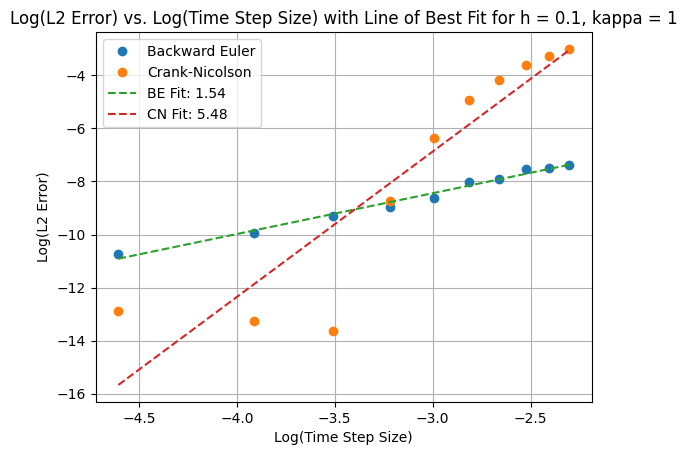

In [ ]:
# Question 2b

tau = np.arange(0.01, 0.11, 0.01)
errors_CN = []
errors_BE = []
k = 1
max_x = 1
max_t = 1
dx = 0.1
for dt in tau:
    analytical = q2_analytical(max_x, dx, max_t, dt, k)
    euler = q2_euler(max_x, dx, max_t, dt, k)
    crank = q2_crank(max_x, dx, max_t, dt, k)

    # Calculate L2 error for each method
    error_BE = calculate_L2_norm(euler, analytical)
    error_CN = calculate_L2_norm(crank, analytical)
    errors_BE.append(error_BE)
    errors_CN.append(error_CN)

log_tau = np.log(tau)
log_errors_BE = np.log(errors_BE)
log_errors_CN = np.log(errors_CN)

plt.figure()
plt.plot(log_tau, log_errors_BE, marker='o', linestyle='', label='Backward Euler')
plt.plot(log_tau, log_errors_CN, marker='o', linestyle='', label='Crank-Nicolson')

# Perform linear regression to find the slope (order of convergence)
slope_BE, intercept_BE, _, _, _ = linregress(log_tau, log_errors_BE)
slope_CN, intercept_CN, _, _, _ = linregress(log_tau, log_errors_CN)

plt.plot(log_tau, intercept_BE + slope_BE * log_tau, '--', label=f'BE Fit: {slope_BE:.2f}')
plt.plot(log_tau, intercept_CN + slope_CN * log_tau, '--', label=f'CN Fit: {slope_CN:.2f}')

plt.xlabel('Log(Time Step Size)')
plt.ylabel('Log(L2 Error)')
plt.title(f'Log(L2 Error) vs. Log(Time Step Size) with Line of Best Fit for h = {dx}, kappa = {k}')
plt.legend()
plt.grid(True)
plt.show()

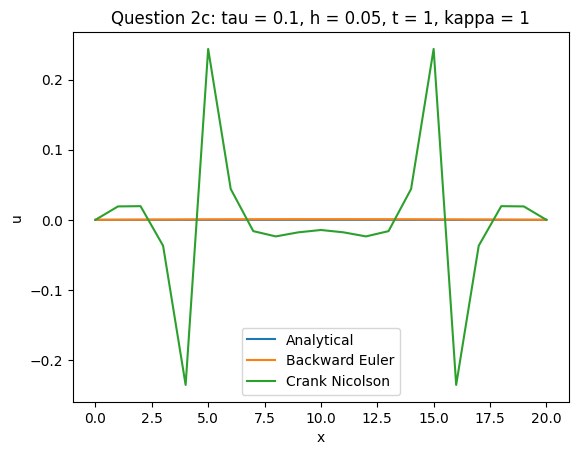

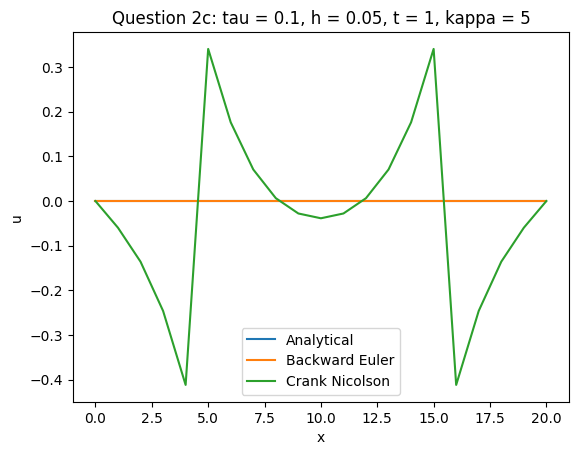

In [ ]:
# Question 2c: Give plot of numerical solutions and analytical solution when tao = 0.1, h = 0.05 at time t = 1, k = 1, k = 5

max_x = 1
dx = 0.05
dt = 0.1  # Time step size
max_t = 1
k_vals = np.array([1, 5])

for k in k_vals:
    analytical = q2_analytical(max_x, dx, max_t, dt, k)
    euler = q2_euler(max_x, dx, max_t, dt, k)
    crank = q2_crank(max_x, dx, max_t, dt, k)

    plt.plot(analytical[:,-1], label=f'Analytical')
    plt.plot(euler[:,-1], label=f'Backward Euler')
    plt.plot(crank[:,-1], label=f'Crank Nicolson')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.title(f'Question 2c: tau = {dt}, h = {dx}, t = 1, kappa = {k}')
    plt.show()

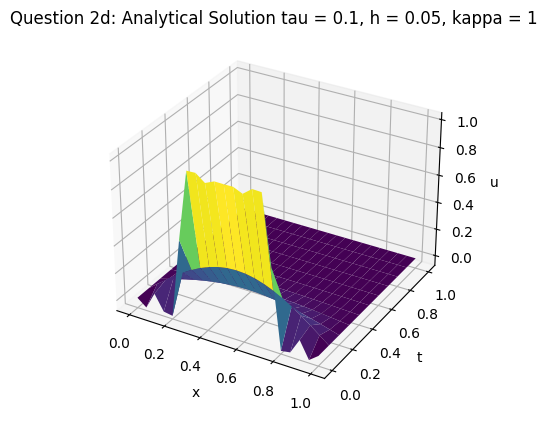

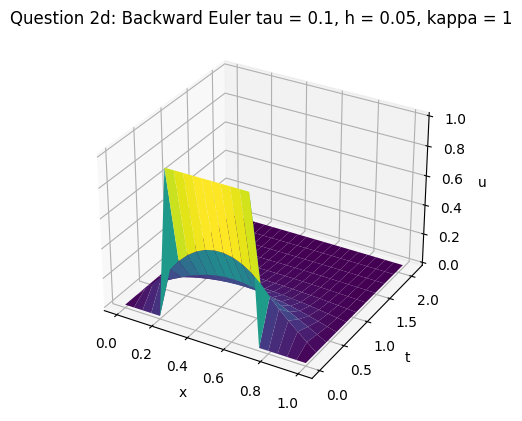

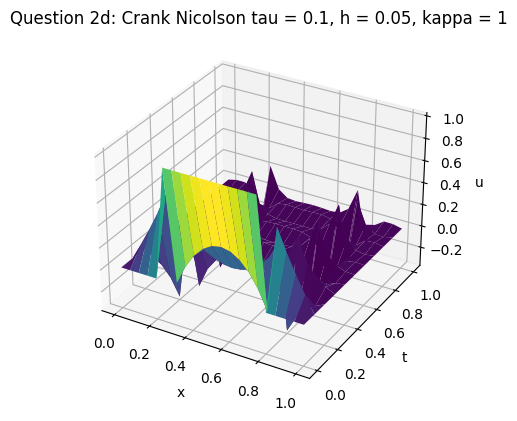

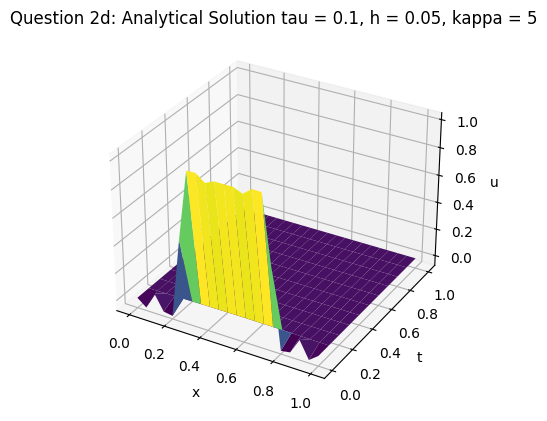

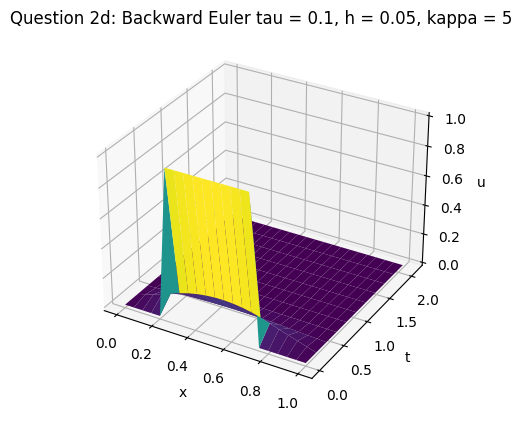

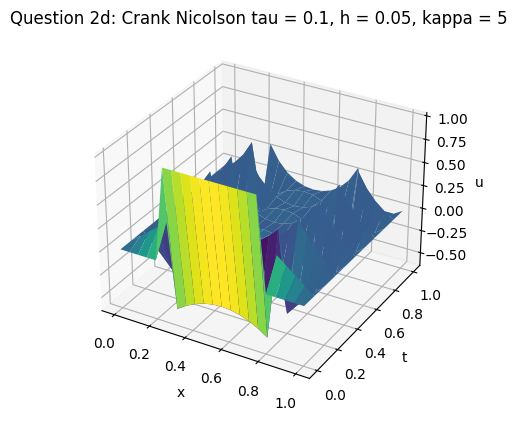

In [ ]:
# Question 2d: Give surface plot of numerical solutions and analytical solution when tao = 0.1, h = 0.05, and k = 1, k = 5

max_x = 1
dx = 0.05
dt = 0.1
kappa = np.array([1, 5])

for k in kappa:
  analytical = q2_analytical(max_x, dx, max_t, dt, k, 1)
  euler = q2_euler(max_x, dx, max_t, dt, k, 1)
  crank = q2_crank(max_x, dx, max_t, dt, k, 1)